In [1]:
%matplotlib inline

from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random
import math

import scipy
from scipy import ndimage

import time

# Split Data

# Train Model

In [3]:
trainset_imoprt = pickle.load(open("../data/kaggle/train_labeled.p", "rb"))
validset_import = pickle.load(open("../data/kaggle/validation.p", "rb"))

Files already downloaded
3000
750


In [4]:
train_loader = torch.utils.data.DataLoader(trainset_imoprt, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset_import, batch_size=64, shuffle=True)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)



In [7]:
model = Net()#pickle.load(open("model.p", "rb"))

In [8]:
# optim.SGD(params, lr=<object>, momentum=0, dampening=0, weight_decay=0)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

# optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = optim.Adam(model.parameters(), lr=args.lr)

In [9]:
# Single channel only
def tensor_imshow(tensor):    
    npimg = tensor.numpy()[0]
    np_imshow(npimg)
    
def np_imshow(npimg):
    plt.figure(1)
    plt.imshow(npimg, cmap='gray')
    plt.show()

In [10]:
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # width and height of the zoomed image
    zh = int(np.round(zoom_factor * h))
    zw = int(np.round(zoom_factor * w))

    # for multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # zooming out
    if zoom_factor < 1:
        # bounding box of the clip region within the output array
        top = (h - zh) // 2
        left = (w - zw) // 2
        # zero-padding
        out = np.zeros_like(img)
        out += np.amin(img)
        out[top:top+zh, left:left+zw] = ndimage.zoom(img, zoom_tuple, **kwargs)

    # zooming in
    elif zoom_factor > 1:
        # bounding box of the clip region within the input array
        top = (zh - h) // 2
        left = (zw - w) // 2
        out = ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # if zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [11]:
# Data Augmentations

# Transforms a tensor into a numpy array
# ONLY FOR SINGLE CHANNEL
def to_npimg(tensor):
    t = (tensor[0]).numpy()
    return t


def random_translate(npimg, min_translate=-0.2, max_translate=0.2):
    
    h, w = npimg.shape
    min_pixels = ((h + w) / 2) * min_translate
    max_pixels = ((h + w) / 2) * max_translate
    shift = int(random.uniform(min_pixels, max_pixels))
    
    return ndimage.interpolation.shift(npimg, shift, mode='nearest')


def random_rotate(npimg, min_rotate=-30, max_rotate=30):
    
    theta = random.randint(int(min_rotate), int(max_rotate + 1))
    return ndimage.interpolation.rotate(npimg, theta, reshape=False, mode='nearest')


def random_scale(npimg, min_scale=0.5, max_scale=1.5):
    
    scale_factor = random.uniform(min_scale, max_scale)
    sc_img = clipped_zoom(npimg, scale_factor, mode='nearest')
    return sc_img
    

# Converts a HxW ndarray into a 1xHxW tensor
def to_tensor(npimg):
    h, w = npimg.shape
    npimg = npimg.reshape(1, h, w)
    return torch.from_numpy(npimg)


        

In [21]:
# CPU only training
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        for i in range(len(data)):
            
            data[i] = transforms.Compose([
                transforms.Lambda(lambda x: to_npimg(x)),
                transforms.Lambda(lambda x: random_gaussian_noise(x)),

#                 transforms.Lambda(lambda x: random_translate(x)),
#                 transforms.Lambda(lambda x: random_rotate(x)),
#                 transforms.Lambda(lambda x: random_scale(x)),
                transforms.Lambda(lambda x: to_tensor(x)),

                ])(data[i])
        tensor_imshow(data[i])

        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

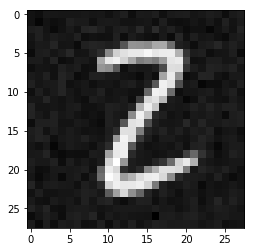

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.282503


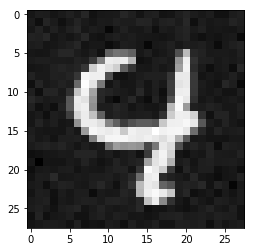

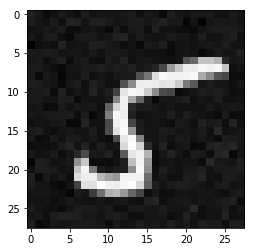

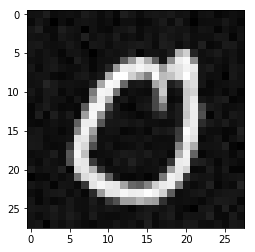

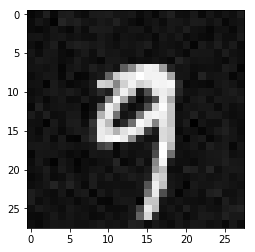

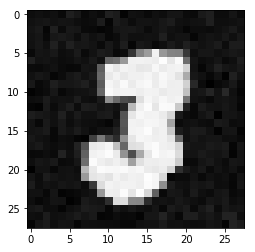

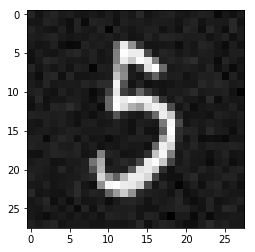

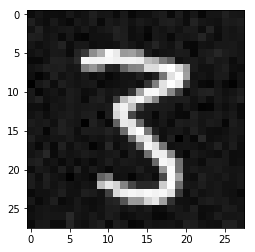

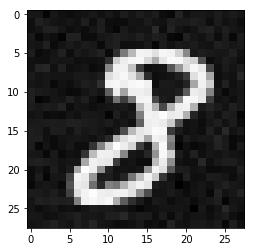

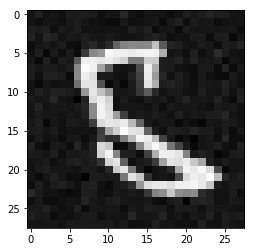

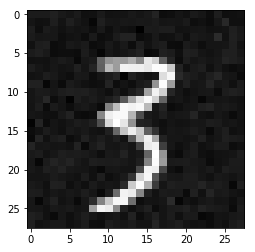

Train Epoch: 1 [640/3000 (21%)]	Loss: 2.264521


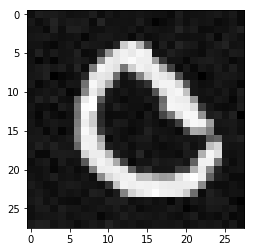

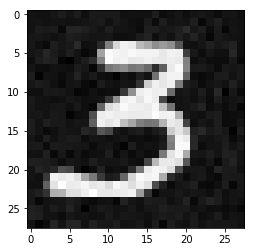

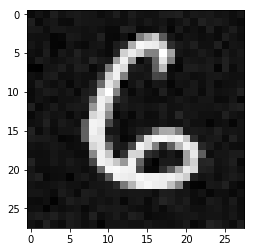

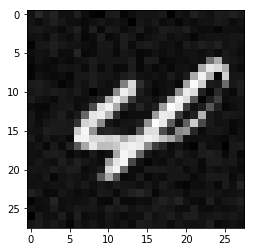

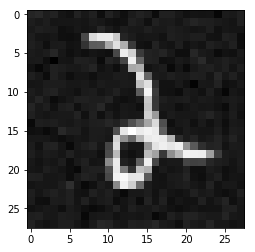

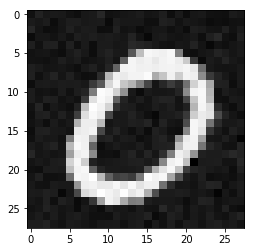

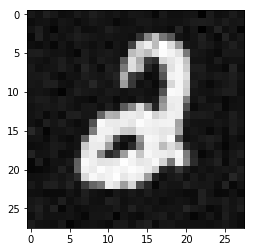

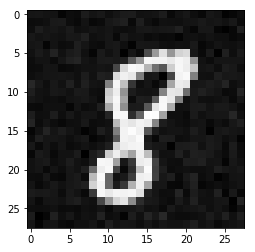

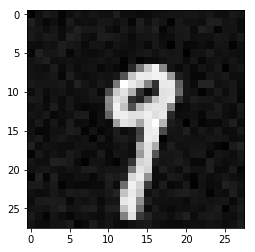

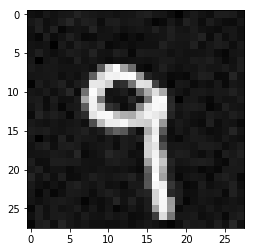

Train Epoch: 1 [1280/3000 (43%)]	Loss: 2.229426


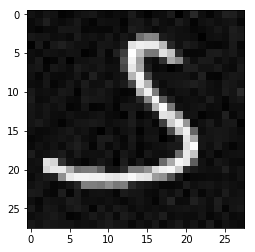

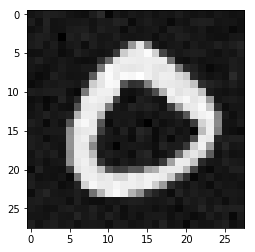

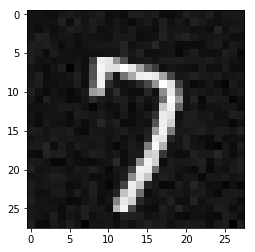

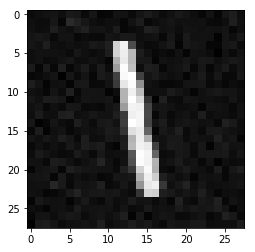

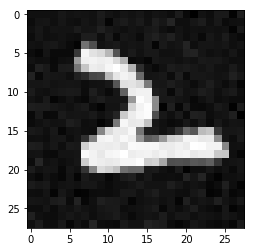

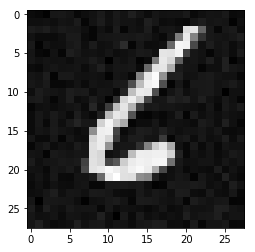

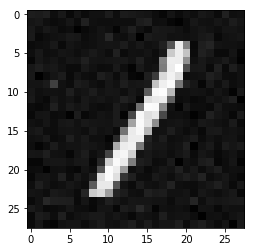

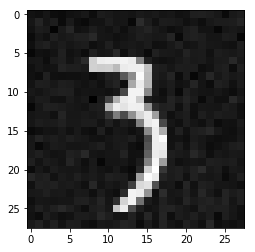

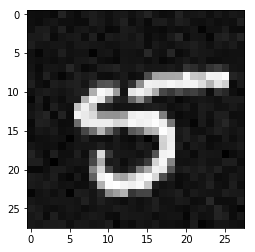

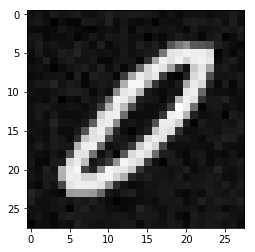

Train Epoch: 1 [1920/3000 (64%)]	Loss: 2.152322


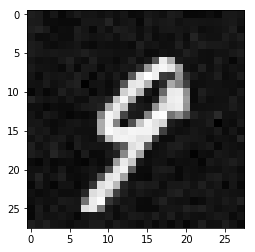

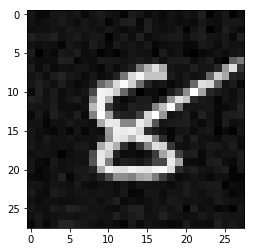

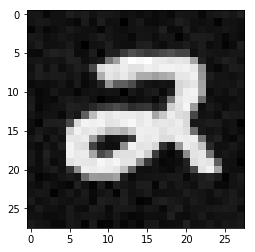

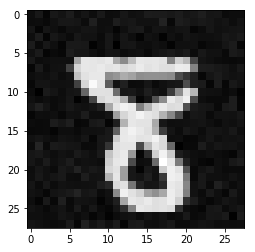

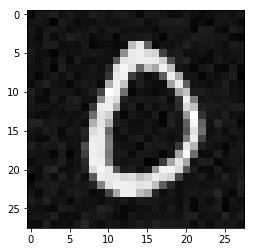

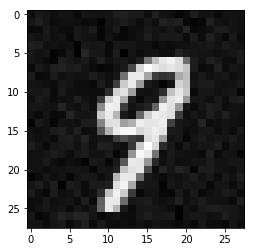

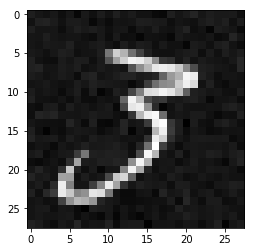

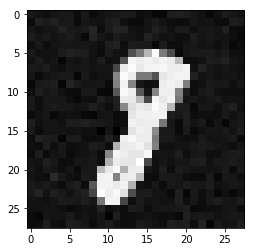

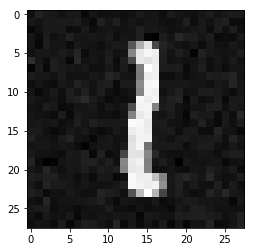

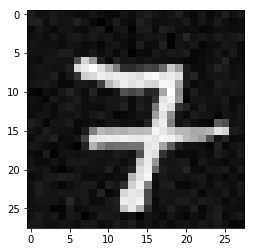

Train Epoch: 1 [2560/3000 (85%)]	Loss: 2.055226


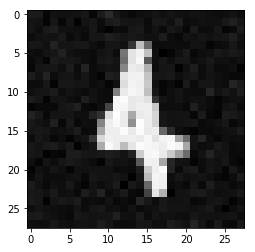

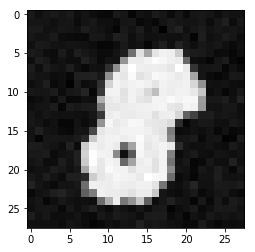

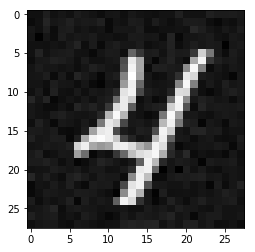

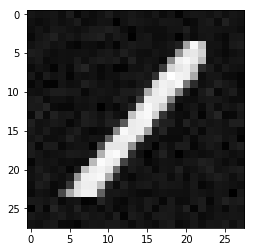

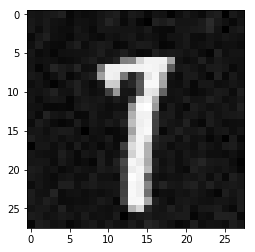

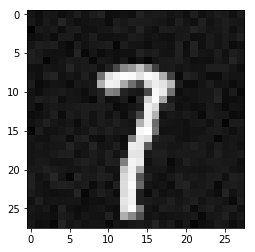

In [22]:
train(1)

In [198]:
def test(epoch, valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:

        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [199]:
for epoch in range(1, 10):
    train(epoch)
    test(epoch, valid_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.299500
Train Epoch: 1 [640/3000 (21%)]	Loss: 2.300411
Train Epoch: 1 [1280/3000 (43%)]	Loss: 2.306949
Train Epoch: 1 [1920/3000 (64%)]	Loss: 2.291730
Train Epoch: 1 [2560/3000 (85%)]	Loss: 2.283439

Test set: Average loss: 2.2728, Accuracy: 1985/10000 (20%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 2.289344
Train Epoch: 2 [640/3000 (21%)]	Loss: 2.268068
Train Epoch: 2 [1280/3000 (43%)]	Loss: 2.259471
Train Epoch: 2 [1920/3000 (64%)]	Loss: 2.265214
Train Epoch: 2 [2560/3000 (85%)]	Loss: 2.269572

Test set: Average loss: 2.2069, Accuracy: 2694/10000 (27%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 2.282565
Train Epoch: 3 [640/3000 (21%)]	Loss: 2.281619
Train Epoch: 3 [1280/3000 (43%)]	Loss: 2.278317
Train Epoch: 3 [1920/3000 (64%)]	Loss: 2.248786
Train Epoch: 3 [2560/3000 (85%)]	Loss: 2.219997

Test set: Average loss: 2.0750, Accuracy: 3481/10000 (35%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 2.213680
Train Epoch: 4 [640/3000 (21%)]	Loss: 2.213913
Train Epoch: 4 [1280/

# Create Sample Submission

In [10]:
testset = pickle.load(open("../data/kaggle/test.p", "rb"))

In [11]:
test_loader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle=False)

## Test Accuuracy

In [12]:
test(1, test_loader)


Test set: Average loss: 0.1179, Accuracy: 9635/10000 (96%)



In [13]:
label_predict = np.array([])
model.eval()
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    temp = output.data.max(1)[1].numpy().reshape(-1)
    label_predict = np.concatenate((label_predict, temp))

In [14]:
label_predict

array([ 7.,  2.,  1., ...,  4.,  5.,  6.])

In [17]:
import pandas as pd
predict_label = pd.DataFrame(label_predict, columns=['label'], dtype=int)
predict_label.reset_index(inplace=True)
predict_label.rename(columns={'index': 'ID'}, inplace=True)

In [18]:
predict_label.head()

,ID,label
0,0,7
1,1,2
2,2,1
3,3,0
4,4,4


In [19]:
predict_label.to_csv('../data/kaggle/sample_submission.csv', index=False)


In [18]:
def random_gaussian_noise(npimg):
    h, w = npimg.shape
    mu, sigma = 0, 0.1
    s = np.random.normal(mu, sigma, h * w)
    s = s.reshape((h,w))
    return npimg + s